## Introduction

In this group project, our objective is to build a model that will predict 5 hand gestures correctly. We will try two different architectures, one using a Convolutional 3D neural network and the other using standard CNN+RNN architecture.

## Importing Libraries

In [ ]:
import numpy as np
import os
import time
# from scipy.misc import imread, imresize
# Since the above is depricated, instead using imageio and skimage library
from skimage.io import imread
from skimage.transform import resize
from skimage.transform import resize as imresize

import datetime
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !pip install --upgrade tensorflow==2.12.0
# !pip install --upgrade keras==2.15.0

In [ ]:
#We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
import keras
from keras import backend as K
tf.random.set_seed(30)

In [ ]:
#checking tensorflow and keras version
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


In [ ]:
# %cp -r drive/MyDrive/Gesture_Recognition/Project_data/Project_data/* .
# %cp drive/MyDrive/Gesture_Recognition/Project_data.zip .
# !unzip drive/MyDrive/Gesture_Recognition/Project_data.zip -d .

In [ ]:
# Constants
TOTAL_FRAME_PER_VIDEO = 30
# DRIVE_PATH = '/content/drive/MyDrive/Gesture_Recognition/'
DRIVE_PATH = './trained_models/'


In [ ]:
# # paths for drive
# TRAIN_CSV = '/content/drive/MyDrive/Gesture_Recognition/Project_data/Project_data/train.csv'
# VAL_CSV = '/content/drive/MyDrive/Gesture_Recognition/Project_data/Project_data/val.csv'
# TRAIN_DIR = '/content/drive/MyDrive/Gesture_Recognition/Project_data/Project_data/train'
# VAL_DIR = '/content/drive/MyDrive/Gesture_Recognition/Project_data/Project_data/val'

In [ ]:
# paths for runtime local
TRAIN_CSV = 'Project_data/train.csv'
VAL_CSV = 'Project_data/val.csv'
TRAIN_DIR = 'Project_data/train'
VAL_DIR = 'Project_data/val'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cp drive/MyDrive/Gesture_Recognition/Project_data.zip .
# !unzip drive/MyDrive/Gesture_Recognition/Project_data.zip -d .

Now we will read the folder names for training and validation. We will set the `batch_size` in such that GPU is utilized to its full capacity. For this different batch sizes will be tried until an error is thrown.

In [ ]:
train_doc = np.random.permutation(open(TRAIN_CSV).readlines())
val_doc = np.random.permutation(open(VAL_CSV).readlines())
batch_size =30  #chosen after experimentation
num_classes = 5

In [ ]:
print('Train Length: ', len(train_doc))
print('Validation Length: ', len(val_doc))

Train Length:  663
Validation Length:  100


## Generator

The generator funtion will preprocess the images as they are of 2 different dimensions. Also it will create a batch of video frames.

In [ ]:
#defining function to preprocess images
def base_generator(t, source_path, batch_size, batch, img_idx, batch_data, batch_labels):
    for folder in range(batch_size):
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
        for idx,item in enumerate(img_idx):
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            # We are only cropping images that are too wide and converting them into 120 * 120 before resizing them to 80*80
            if image.shape[1]==160:
                image = imresize(image[:,20:140,:],(80,80)).astype(np.float32)
            else:
                image = imresize(image,(80,80)).astype(np.float32)

            batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0])) * 100 / np.std(image[:,:,0])
            batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1])) * 100 / np.std(image[:,:,1])
            batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2])) * 100 / np.std(image[:,:,2])

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [ ]:
batch_size = 30

In [ ]:
#defining generator to create a batch of vedio frames
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,16,80,80,3))
            batch_labels = np.zeros((batch_size,5))

            yield base_generator(t, source_path, batch_size, batch, img_idx, batch_data, batch_labels)

        remaining_batches = len(t)%batch_size
        if (remaining_batches) != 0:
            batch_data = np.zeros((remaining_batches,16,80,80,3))
            batch_labels = np.zeros((remaining_batches,5))

            yield base_generator(t, source_path, remaining_batches, batch, img_idx, batch_data, batch_labels)

In [ ]:
# Get the current date and time
curr_dt_time = datetime.datetime.now()

# Define paths for the training and validation datasets
train_path = TRAIN_DIR
val_path = VAL_DIR

# Calculate and print the number of training sequences
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

# Calculate and print the number of validation sequences
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# Set the number of epochs for training
num_epochs = 50
print('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 50


### Validating Generator

In [ ]:
def validate_generator(path, doc, batch_size):
  gen = generator(path, doc, batch_size)
  batch_data, batch_labels = next(gen)
  return batch_data, batch_labels

# train data
train_batch_data, train_batch_labels = validate_generator(train_path, train_doc, batch_size)
print('Train Data: ', train_batch_data.shape)

# val data
val_batch_data, val_batch_labels = validate_generator(val_path, val_doc, batch_size)
print('Val Data: ', val_batch_data.shape)

Source path =  Project_data/train ; batch size = 30
Train Data:  (30, 16, 80, 80, 3)
Source path =  Project_data/val ; batch size = 30
Val Data:  (30, 16, 80, 80, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


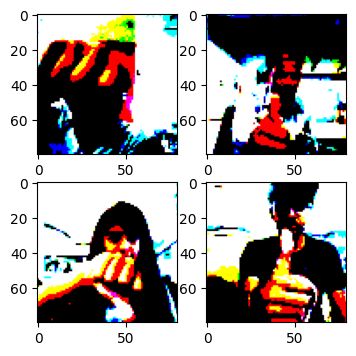

In [ ]:
#displaying few images from the training and validation set
fig, ax = plt.subplots(2,2, figsize=(4,4))
ax[0,0].imshow(train_batch_data[20,10,:,:,:])
ax[0,1].imshow(train_batch_data[26,10,:,:,:])

ax[1,0].imshow(val_batch_data[20,10,:,:,:])
ax[1,1].imshow(val_batch_data[26,10,:,:,:])
plt.show()

## Model Building
Using different functionalities that Keras provides different models are built. `Conv3D` and `MaxPooling3D` libraries are used for building 3D convolution model. `TimeDistributed` library is used while building Conv2D + RNN model. Aim is to design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model Imports

In [ ]:
# Importing Tensorflow.Keras Libraries

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD

### Model Utils

In [ ]:
#defining function for plotting history for accuracy and loss
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())

    # fig, ax = plt.subplots(1,2, figsize=(16,8))

    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
# defining funtion that sets up and returns callbacks for model training
def model_callbacks(folder_name):
  model_name = DRIVE_PATH + str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

  if not os.path.exists(model_name):
      os.mkdir(model_name)

  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here

  return [LR], [checkpoint]

In [ ]:
# Calculates steps per epoch to ensure all training sequences are processed, including any leftover samples
def get_steps_per_epoch(num_train_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    return steps_per_epoch

In [ ]:
# Calculates validation steps to ensure all validation sequences are processed, including any leftover samples.
def get_validation_steps(num_train_sequences, batch_size):
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return validation_steps

### Common Variables

In [ ]:
# Train and Validation Generators

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

steps_per_epoch = get_steps_per_epoch(num_train_sequences, batch_size)
validation_steps = get_validation_steps(num_train_sequences, batch_size)

### Model 1: Without Normalization and Dropouts

In [ ]:
# Initializing two lists of callbacks for 'Model1' to monitor and adjust training progress
callbacks_list, callbacks_list2 = model_callbacks('Model1')

In [ ]:
model1 = Sequential()
model1.add(Conv3D(64,kernel_size=(3,3,3),activation='relu',input_shape=(16,80,80,3),padding='same',data_format='channels_last'))
model1.add(MaxPooling3D(pool_size=(2,2,1),strides=(2,2,1)))

model1.add(Conv3D(128,(3,3,3),activation='relu', padding='same'))
model1.add(MaxPooling3D(pool_size=(2,2,1),strides=(2,2,1)))

model1.add(Conv3D(256,(3,3,3),activation='relu',padding='same'))
model1.add(Conv3D(256,(3,3,3),activation='relu',padding='same'))
model1.add(MaxPooling3D(pool_size=(2,2,1),strides=(2, 2, 2)))

model1.add(Flatten())

model1.add(Dense(128,activation='relu'))
model1.add(Dense(64,activation='relu'))

model1.add(Dense(5,activation='softmax'))

In [ ]:
# Compiling 'model1 and printing model summary.
adam = Adam(learning_rate=0.01)
model1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 80, 80, 64)    5248      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 8, 40, 80, 64)    0         
 3D)                                                             
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 40, 80, 128)    221312    
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 4, 20, 80, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 4, 20, 80, 256)    884992    
                                                                 
 conv3d_15 (Conv3D)          (None, 4, 20, 80, 256)   

In [ ]:
# Recording the current time to track the start of a timing operation
ts_start = time.time()

In [ ]:
# Training model1
history1 = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1,
                   callbacks=callbacks_list, validation_data=val_generator,
                   validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - 3528s 152s/step - loss: 741497.8125 - categorical_accuracy: 0.1780 - val_loss: 1.6211 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/5
23/23 [==============================] - 2239s 97s/step - loss: 1.6122 - categorical_accuracy: 0.2021 - val_loss: 1.6043 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/5
23/23 [==============================] - 2395s 104s/step - loss: 1.6096 - categorical_accuracy: 0.2051 - val_loss: 1.6098 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 4/5
23/23 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.2051  
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
23/23 [==============================] - 2398s 104s/step - loss: 1.6095 - categorical_accuracy: 0.2051 - val_loss: 1.6062 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 5/5
23/23 [==============================] - 2

In [ ]:
# Printing time taken for model training
print('Model1 finishes in: ', time.time() - ts_start, ' secs')

Model1 finishes in:  12965.133923768997  secs


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


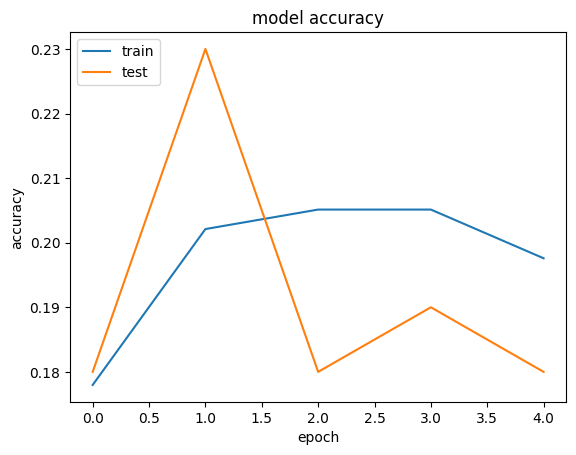

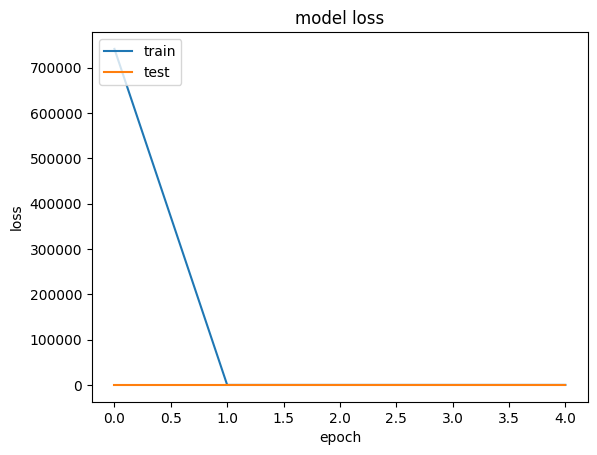

In [ ]:
# Plotting model accuracy and loss
plot_loss_accuracy(history1)

### Inference:
* The model shows poor convergence, with high initial loss and minimal improvement over epochs, suggesting it struggles to learn patterns from the data.
* The categorical accuracy remains low, which indicates that the model may not be effectively capturing key features for classification.
* Reducing the learning rate improved stability slightly, but further tuning, such as adjusting the architecture or adding regularization techniques, may be needed to enhance performance.

In [ ]:
model1.save('./trained_models/model1.h5')

In [ ]:
# # Recreate the exact same model, including its weights and the optimizer
# load_model = tf.keras.models.load_model('final_model.h5')

# # Show the model architecture
# load_model.summary()

### Model 2: Using Batch Normalization and adding Dropouts to the Model

In [ ]:
# Initializing two lists of callbacks for 'Model2' to monitor and adjust training progress
callbacks_model2, callbacks2_model2 = model_callbacks('Model2')

In [ ]:
model2 = Sequential()

model2.add(Conv3D(64,kernel_size=(3,3,3),activation='relu',input_shape=(16,80,80,3),
                 padding='same',data_format='channels_last'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,1)))

model2.add(Conv3D(128,(3,3,3),activation='relu',padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,1)))

model2.add(Conv3D(256,(3,3,3),activation='relu',padding='same'))
model2.add(BatchNormalization())

model2.add(Conv3D(256,(3,3,3),activation='relu',padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,1)))

model2.add(Flatten())

model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(5,activation='softmax'))

In [ ]:
adam = Adam(learning_rate = 0.01)
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 80, 80, 64)    5248      
                                                                 
 batch_normalization (BatchN  (None, 16, 80, 80, 64)   256       
 ormalization)                                                   
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 40, 80, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 40, 80, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 40, 80, 128)   512       
 hNormalization)                                                 
                                                      

In [ ]:
ts_start = time.time()

In [ ]:
history2 = model2.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1,
                   callbacks=callbacks_model2, validation_data=val_generator,
                   validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/5
23/23 [==============================] - 2459s 107s/step - loss: 427.4858 - categorical_accuracy: 0.2609 - val_loss: 66912.1562 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/5
23/23 [==============================] - 2437s 106s/step - loss: 34.3256 - categorical_accuracy: 0.2489 - val_loss: 5795.7485 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 3/5
23/23 [==============================] - 2402s 104s/step - loss: 6.6092 - categorical_accuracy: 0.2564 - val_loss: 1440.3409 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 4/5
23/23 [==============================] - 2423s 105s/step - loss: 2.9600 - categorical_accuracy: 0.2323 - val_loss: 691.4372 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 5/5
23/23 [==============================] - 2409s 105s/step - loss: 3.8734 - categorical_accuracy: 0.2353 - val_loss: 342.4606 - val_categorical_accuracy: 0.1800 - lr: 0.0100


In [ ]:
print('Model2 finishes in: ', time.time() - ts_start, ' secs')

Model2 finishes in:  12135.34614443779  secs


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


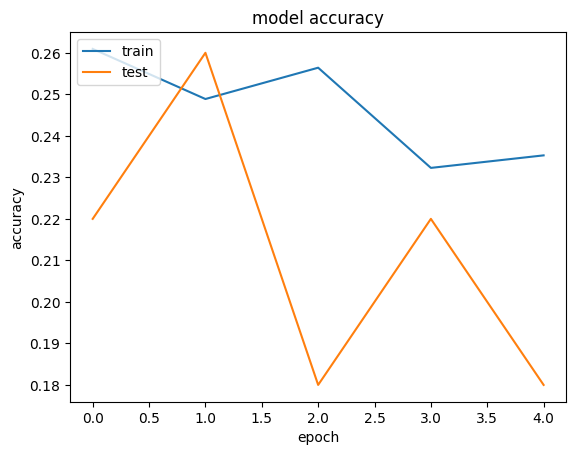

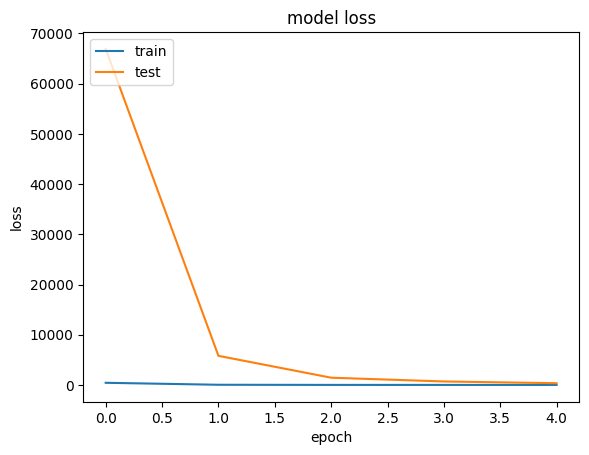

In [ ]:
plot_loss_accuracy(history2)

### Inference:
* This model also shows poor learning performance, with high initial and validation losses that decrease slowly over epochs, indicating that it struggles to generalize well.
* The categorical accuracy remains low and stagnant, suggesting the model is not effectively distinguishing between classes.
* The use of batch normalization and dropout did not significantly improve accuracy, implying the need for further architecture tuning

In [ ]:
model2.save('./trained_models/model2.h5')

### Model3: A deeper model with more parameters

In [ ]:
# Initializing two lists of callbacks for 'Model3' to monitor and adjust training progress
callbacks_model3, callbacks2_model3 = model_callbacks('Model3')

In [ ]:
model3 = Sequential()

model3.add(Conv3D(32,(3,3,3),padding='same',input_shape=(16,80,80,3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

model3.add(Conv3D(64,(3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

model3.add(Conv3D(128,(3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

model3.add(Conv3D(256,(3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

model3.add(Flatten())

model3.add(Dropout(0.5))
model3.add(Dense(128,activation='relu'))

model3.add(Dropout(0.5))
model3.add(Dense(5,activation='softmax'))

In [ ]:
model3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 80, 80, 32)    2624      
                                                                 
 batch_normalization_4 (Batc  (None, 16, 80, 80, 32)   128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 16, 80, 80, 32)    0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 8, 40, 40, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 40, 40, 64)     55360     
                                                                 
 batch_normalization_5 (Batc  (None, 8, 40, 40, 64)   

In [ ]:
ts_start = time.time()

In [ ]:
history3 = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1,
                   callbacks=callbacks_model3, validation_data=val_generator,
                   validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/15
23/23 [==============================] - 288s 12s/step - loss: 3.2803 - categorical_accuracy: 0.2368 - val_loss: 7.8946 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - 283s 12s/step - loss: 1.5595 - categorical_accuracy: 0.2172 - val_loss: 1.6259 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - 280s 12s/step - loss: 1.5288 - categorical_accuracy: 0.3047 - val_loss: 1.9573 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 4/15
23/23 [==============================] - ETA: 0s - loss: 1.5315 - categorical_accuracy: 0.3107 
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
23/23 [==============================] - 282s 12s/step - loss: 1.5315 - categorical_accuracy: 0.3107 - val_loss: 1.6611 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 5/15
23/23 [==============================] - 280s 12s/step - loss: 1.5236 - categorical_accuracy: 0.2986 

In [ ]:
print('Model3 finishes in: ', time.time() - ts_start, ' secs')

Model3 finishes in:  4235.83864736557  secs


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


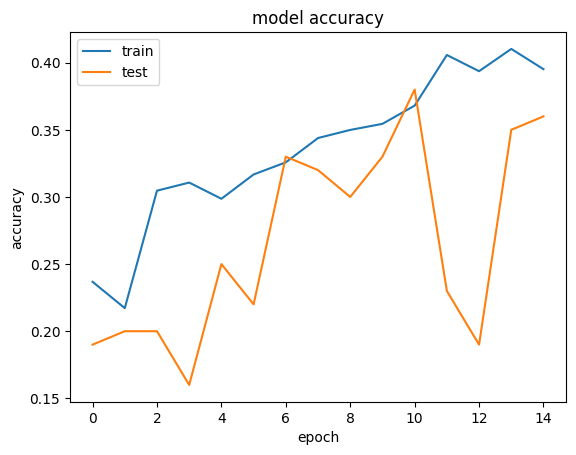

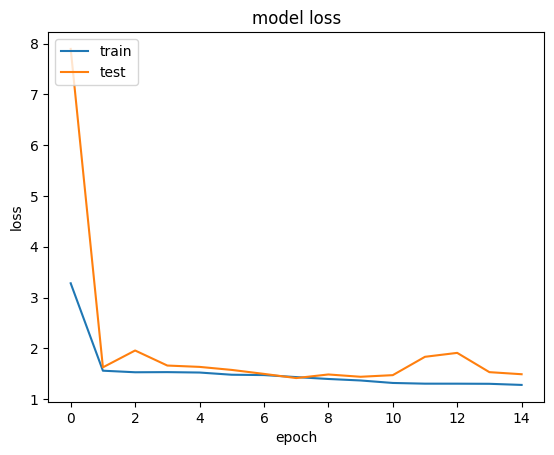

In [ ]:
plot_loss_accuracy(history3)

In [ ]:
model3.save('./trained_models/model3.h5')

### Inference:
* Training loss decreased from 3.2803 to 1.2796, but validation accuracy improved only slightly from 19% to 36%, indicating potential overfitting.
* The learning rate was reduced during training, suggesting a need for better tuning for improved performance.

### Model4: Reducing Learning Rate in this Model

In [ ]:
callbacks_model4, callbacks2_model4 = model_callbacks('Model4')

In [ ]:
model4 = Sequential()

model4.add(Conv3D(16,(3,3,3),padding='same',activation='relu',input_shape=(16,80,80,3)))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(32,(3,3,3),padding='same',activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(64,(3,3,3),padding='same',activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(128,(3,3,3),padding='same',activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Flatten())

model4.add(Dense(64,activation='relu'))
model4.add(BatchNormalization())

model4.add(Dropout(0.3))
model4.add(Dense(64,activation='relu'))
model4.add(BatchNormalization())

model4.add(Dropout(0.3))
model4.add(Dense(5,activation='softmax'))

In [ ]:
adam = Adam(amsgrad=True, learning_rate=0.0005)
model4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 batch_normalization_14 (Bat  (None, 16, 80, 80, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 batch_normalization_15 (Bat  (None, 8, 40, 40, 32)    128       
 chNormalization)                                                
                                                      

In [ ]:
ts_start = time.time()

In [ ]:
history4 = model4.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                   callbacks=callbacks_model4, validation_data=val_generator,
                   validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/20
23/23 [==============================] - 147s 6s/step - loss: 1.9545 - categorical_accuracy: 0.3379 - val_loss: 5.8800 - val_categorical_accuracy: 0.2100 - lr: 5.0000e-04
Epoch 2/20
23/23 [==============================] - 141s 6s/step - loss: 1.3777 - categorical_accuracy: 0.4857 - val_loss: 4.2215 - val_categorical_accuracy: 0.3900 - lr: 5.0000e-04
Epoch 3/20
23/23 [==============================] - 138s 6s/step - loss: 1.1571 - categorical_accuracy: 0.5520 - val_loss: 6.0064 - val_categorical_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 4/20
23/23 [==============================] - 140s 6s/step - loss: 0.9816 - categorical_accuracy: 0.6440 - val_loss: 1.6545 - val_categorical_accuracy: 0.4200 - lr: 5.0000e-04
Epoch 5/20
23/23 [==============================] - 146s 6s/step - loss: 0.7964 - categorical_accuracy: 0.7119 - val_loss: 1.2674 - val_categorical_accuracy: 0.4900 - lr: 5.0000e-04
Epoch 6/20
23/23 [==============================] - 149s 7s/step - loss: 0.7187 - categori

In [ ]:
print('Model4 finishes in: ', time.time() - ts_start, ' secs')

Model4 finishes in:  2807.075450658798  secs


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


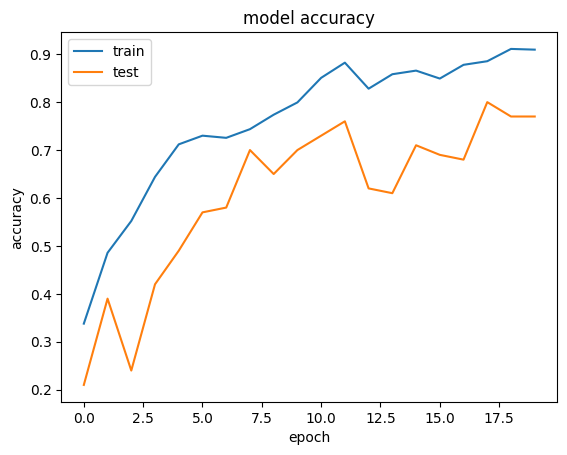

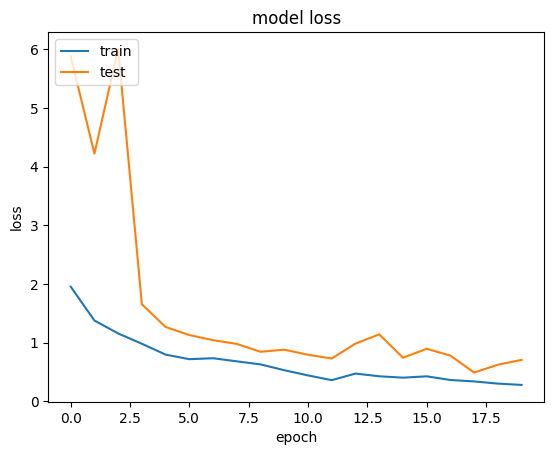

In [ ]:
plot_loss_accuracy(history4)

In [ ]:
model4.save('./trained_models/model4.h5')

### Inference
* Training accuracy improved significantly from 33.8% to 90.9% over 20 epochs, while validation accuracy reached 77%.
* The training loss decreased from 1.95 to 0.28, indicating effective learning; however, fluctuations in validation loss suggest potential overfitting.
* Learning rate adjustments were made during training to enhance performance further.

### Model 5: CNN + RNN Simple Model

In [ ]:
callbacks_model5, callbacks2_model5 = model_callbacks('Model5')

In [ ]:
model5 = Sequential()
model5.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),
                         input_shape=(16,80,80,3)))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(TimeDistributed(Conv2D(256,(3,3),padding='same',activation='relu')))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(TimeDistributed(Flatten()))
model5.add(GRU(64))
model5.add(Dense(64,activation='relu'))
model5.add(Dropout(0.50))
model5.add(Dense(5,activation='softmax'))

In [ ]:
model5.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_11 (TimeDi  (None, 16, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 16, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 20, 20, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 20, 20, 64)  

In [ ]:
ts_start = time.time()

In [ ]:
history5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1,
                   callbacks=callbacks_model5, validation_data=val_generator,
                   validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/15
23/23 [==============================] - 142s 6s/step - loss: 1.7927 - categorical_accuracy: 0.1810 - val_loss: 1.6125 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - 144s 7s/step - loss: 1.6797 - categorical_accuracy: 0.2112 - val_loss: 1.6059 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - 134s 6s/step - loss: 1.6492 - categorical_accuracy: 0.2051 - val_loss: 1.6020 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 4/15
23/23 [==============================] - 138s 6s/step - loss: 1.6214 - categorical_accuracy: 0.2066 - val_loss: 1.6123 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 5/15
23/23 [==============================] - ETA: 0s - loss: 1.6265 - categorical_accuracy: 0.2066
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
23/23 [==============================] - 137s 6s/step - loss: 1.6265 - categorical_accuracy: 0.2066 - val_

In [ ]:
print('Model5 finishes in: ', time.time() - ts_start, ' secs')

Model5 finishes in:  2088.5285930633545  secs


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


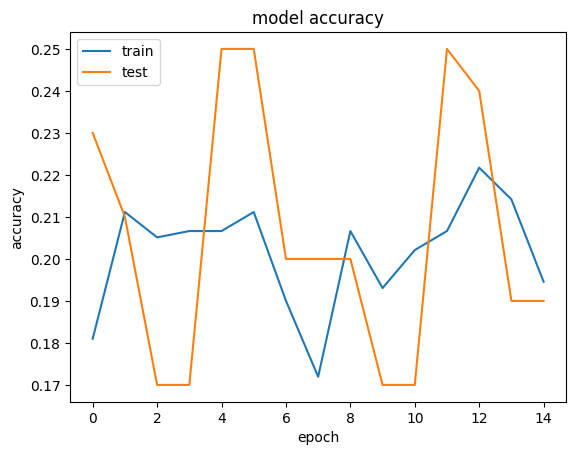

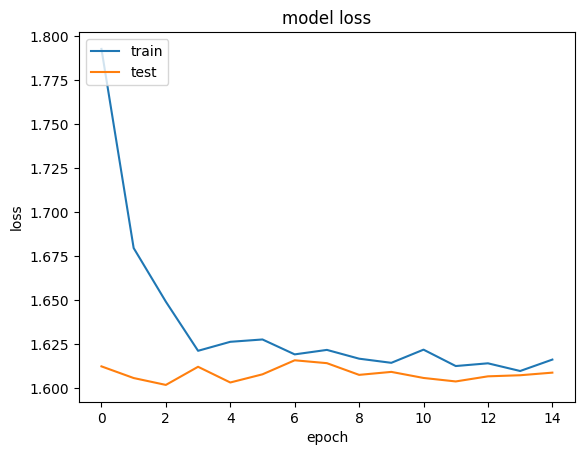

In [ ]:
plot_loss_accuracy(history5)

In [ ]:
model5.save('./trained_models/model5.h5')

### Inference
* The model employs a TimeDistributed architecture combining 2D convolutional layers and a GRU layer to analyze sequences of frames for classification into five categories.
* However, training accuracy plateaued around 19-22% with a loss fluctuating around 1.61 over 15 epochs, indicating limited learning.
* Validation accuracy remained low, peaking at 25%, suggesting that the model struggled to generalize effectively from the training data.

### Model 6: CNN + GRU also adding Batch Normalization in this Model

In [ ]:
callbacks_model6, callbacks2_model6 = model_callbacks('Model6')

In [ ]:
model6 = Sequential()

model6.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),
                         input_shape=(16,80,80,3)))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(TimeDistributed(Conv2D(256,(3,3),padding='same',activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(TimeDistributed(Flatten()))
model6.add(GRU(64))
model6.add(Dense(64,activation='relu'))
model6.add(Dropout(0.50))
model6.add(Dense(5,activation='softmax'))

In [ ]:
model6.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model6.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeDi  (None, 16, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 16, 80, 80, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 16, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 16, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 16, 40, 40, 32) 

In [ ]:
ts_start = time.time()

In [ ]:
history6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1,
                   callbacks=callbacks_model6, validation_data=val_generator,
                   validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/30
23/23 [==============================] - 150s 7s/step - loss: 1.7504 - categorical_accuracy: 0.1900 - val_loss: 1.6192 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - 140s 6s/step - loss: 1.6445 - categorical_accuracy: 0.1870 - val_loss: 1.6199 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - 148s 7s/step - loss: 1.6202 - categorical_accuracy: 0.1991 - val_loss: 1.6167 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 4/30
23/23 [==============================] - 143s 6s/step - loss: 1.6180 - categorical_accuracy: 0.2323 - val_loss: 1.6028 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 5/30
23/23 [==============================] - 141s 6s/step - loss: 1.6119 - categorical_accuracy: 0.2051 - val_loss: 1.6034 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 6/30
23/23 [==============================] - ETA: 0s - loss: 1.6121 - categorical_accuracy: 0.1931
Epoc

In [ ]:
print('Model6 finishes in: ', time.time() - ts_start, ' secs')

Model6 finishes in:  4247.057660579681  secs


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


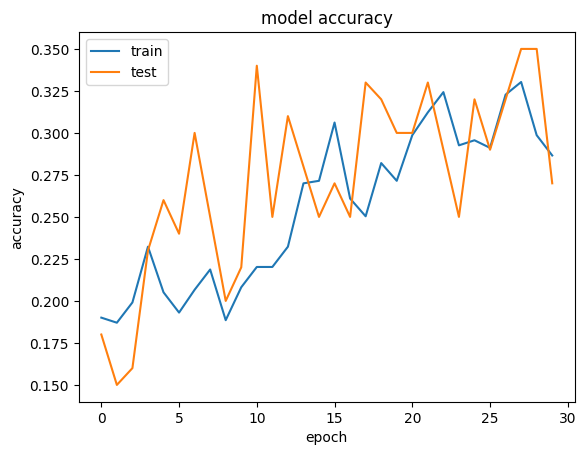

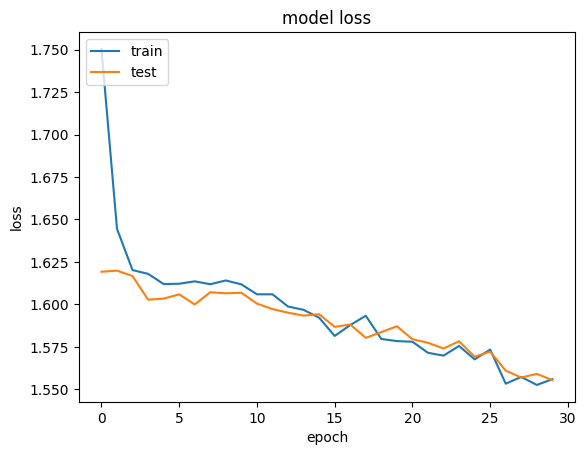

In [ ]:
plot_loss_accuracy(history6)

In [ ]:
model6.save('./trained_models/model6.h5')

### Inference
* The model incorporates Batch Normalization layers to stabilize learning while utilizing a TimeDistributed structure for analyzing sequences of frames in a classification task.
* Over 30 epochs, training accuracy improved to around 33%, with validation accuracy peaking at 35%, indicating some learning progress but overall inconsistency.
* Despite these gains, the model's performance on the validation set remained relatively low, with the loss reducing only slightly to 1.56, suggesting potential issues with feature extraction or class representation in the dataset.

### Model 7: CNN + LSTM(with more neurons) also using Batch Normalization in this Model

In [ ]:
callbacks_model7, callbacks2_model7 = model_callbacks('Model7')

In [ ]:
model7 = Sequential()

model7.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),
                         input_shape=(16,80,80,3)))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2,2))))
model7.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2,2))))
model7.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2,2))))
model7.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
model7.add(TimeDistributed(MaxPooling2D((2,2))))
model7.add(TimeDistributed(Conv2D(256,(3,3),padding='same',activation='relu')))
model7.add(TimeDistributed(MaxPooling2D((2,2))))
model7.add(TimeDistributed(Flatten()))
model7.add(LSTM(128))
model7.add(Dense(64,activation='relu'))
model7.add(Dropout(0.50))
model7.add(Dense(5,activation='softmax'))

In [ ]:
model7.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model7.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, 16, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 16, 80, 80, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 16, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 16, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 16, 40, 40, 32) 

In [ ]:
ts_start = time.time()

In [ ]:
history7 = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                      verbose=1, callbacks=callbacks2_model7,validation_data=val_generator,
                      validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.6676 - categorical_accuracy: 0.2262
Epoch 1: val_loss improved from inf to 1.58990, saving model to ./trained_models/Model7_2024-10-0612_34_11.751468\model-00001-1.66756-0.22624-1.58990-0.23000.weights.h5
23/23 [==============================] - 143s 6s/step - loss: 1.6676 - categorical_accuracy: 0.2262 - val_loss: 1.5899 - val_categorical_accuracy: 0.2300
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.5761 - categorical_accuracy: 0.2655
Epoch 2: val_loss improved from 1.58990 to 1.56076, saving model to ./trained_models/Model7_2024-10-0612_34_11.751468\model-00002-1.57606-0.26546-1.56076-0.39000.weights.h5
23/23 [==============================] - 142s 6s/step - loss: 1.5761 - categorical_accuracy: 0.2655 - val_loss: 1.5608 - val_categorical_accuracy: 0.3900
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.5633 - categorical_accuracy: 0.2775
Epoch 3: val_loss did not improv

In [ ]:
print('Model7 finishes in: ', time.time() - ts_start, ' secs')

Model7 finishes in:  6892.579515695572  secs


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


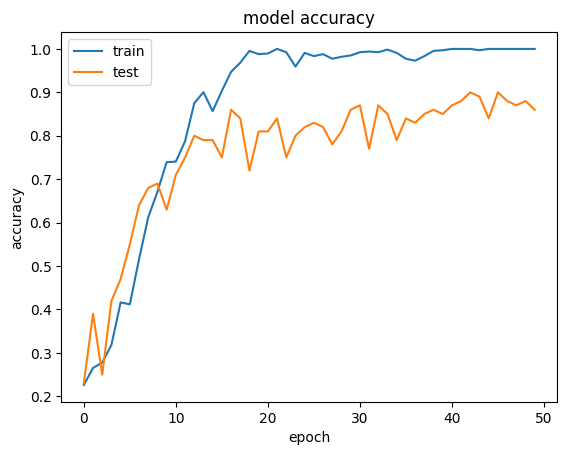

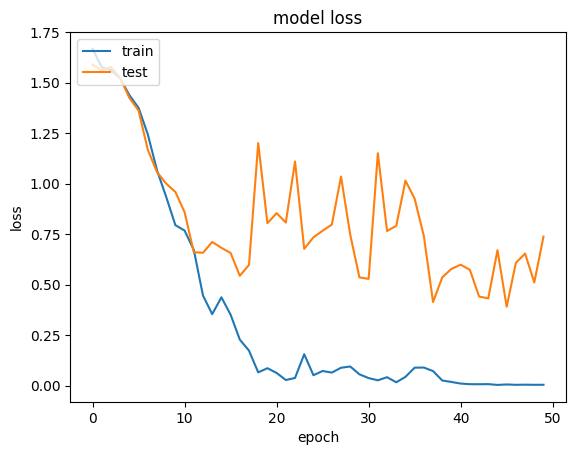

In [ ]:
plot_loss_accuracy(history7)

In [ ]:
model7.save('./trained_models/model7.h5')

### Inference
* The model demonstrates effective training progress, with a notable increase in categorical accuracy from 22.62% in the first epoch to 99.25% by the 31st epoch.
* The validation loss decreased significantly, particularly from 1.6676 to 0.5283, indicating improved generalization and performance on unseen data.
* However, there are signs of potential overfitting, as validation accuracy fluctuated while training accuracy continued to rise.

## CNN + RNN Architecture using Transfer Learning

We first define the sequence of indices we wish to use for the frames to be considered in our training and validation.

In [ ]:
idx_seq = list(range(5,30,2))

### Generator


Generator function is used to import batches of data as the training proceeds since having the entire data in memory is impractical while dealing with large datasets such as the current one. Here,
- The sequence of image indeces to be considered will be used to determine which frames will finally get used in model training and evaluation.
- Image dimensions are chosen to be $80\times80$ since we have images of two different dimensions in our dataset. Appropriate cropping and resizing is done within this code.
- Normalization of images is done to ensure data is consistent and in the same scale. This helps in the training process for gradient descent.
- Batch labels are converted to one-hot encoding vectors to help with the classification tasks.
- The code is made robust enough to handle the case when the number of training datapoints isn't divisible by the chosen batch size. This edge case is handled by adding one additional batch containing the remaining data points.
- The generator function finally yields the batch data and the corresponding one-hot encoded label vector which the model can use for training and validation.

This custom generator function is written since the keras generator function doesn't allow customization for our specific usecase.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)

    img_idx = idx_seq
    x = len(img_idx)

    y = 80
    z = 80

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size  # Calculate number of full batches

        for batch in range(num_batches):  # Iterate over full batches
            batch_data = np.zeros((batch_size, x, y, z, 3))  # Shape (batch_size, frames, height, width, channels)
            batch_labels = np.zeros((batch_size, 5))  # 5 possible gesture classes

            for folder in range(batch_size):  # Iterate over each video in the batch
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):  # Iterate over frames/images
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image_resized = imresize(image, (y, z), preserve_range=True)  # Resize to (y, z)

                    # Normalize the image
                    batch_data[folder, idx, :, :, 0] = image_resized[:, :, 0] / 255.0  # Red channel
                    batch_data[folder, idx, :, :, 1] = image_resized[:, :, 1] / 255.0  # Green channel
                    batch_data[folder, idx, :, :, 2] = image_resized[:, :, 2] / 255.0  # Blue channel

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1  # One-hot encoding of the label

            yield batch_data, batch_labels  # Yield the batch data and labels

        # Process leftover data points after full batches
        if len(folder_list) % batch_size != 0:
            leftover_folders = len(folder_list) - num_batches * batch_size
            batch_data = np.zeros((leftover_folders, x, y, z, 3))
            batch_labels = np.zeros((leftover_folders, 5))
            batch = len(folder_list)//batch_size

            for folder in range(leftover_folders):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item])

                    # cropping images that are wide to get them to 120 * 120
                    # and resizing them to 80*80
                    if image.shape[1]==160:
                        image = imresize(image[:,20:140,:],(80,80)).astype(np.float32)
                    else:
                        image = imresize(image,(80,80)).astype(np.float32)

                    image_resized = imresize(image, (y, z), preserve_range=True)

                    batch_data[folder, idx, :, :, 0] = image_resized[:, :, 0].astype(np.float32) / 255.0
                    batch_data[folder, idx, :, :, 1] = image_resized[:, :, 1].astype(np.float32) / 255.0
                    batch_data[folder, idx, :, :, 2] = image_resized[:, :, 2].astype(np.float32) / 255.0

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

**Each video is represented above in the generator as (number of images, height, width, number of channels).**

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 100
print ('# epochs =', num_epochs)
batch_size = 16
print ('batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 100
batch size = 100


### Plotting Function

We now create a custom plotting function that can plot accuracy and loss for training and validation phases of the model for each epoch. This helps us easily visualize and understand the evolution of the training process. This also allows us to choose the best model and revert back to a previous model if we had overfitted it by running for too long.

In [ ]:
def plot(history):
    num_epochs = len(history.history['loss'])

    acc = history.history['categorical_accuracy']
    val_acc = history.history.get('val_categorical_accuracy', [])

    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))

    # Plot Training and Validation Accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot Training and Validation Loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

### Specific Library Imports

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, TimeDistributed, Flatten, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

### Call-backs

After having experimented with various batch sizes and learning rates, we noticed that higher batch sizes led to overfitting since the model parameters weren't getting updated enough. The training data we have is also limitted (only about 650 videos), hence we decide to use 16 as the batch size.

We define an adaptive learning rate that gets halved whenever the validation loss plateaus for more than 3 epochs. We also define an early stopping criteria if the model performance in terms of validation loss doesn't improve for more than 10 epochs. This allows us to choose higher number of epochs knowing that the execution will terminate when the learning isn't happening as expected.

We also define a method that will save the model weights to a folder which can later be retrieved as per requirement.

In [ ]:
MODEL_PATH = "saved_models"
os.makedirs(MODEL_PATH, exist_ok=True)
def setup_callbacks(folder_name):
    curr_dt_time = datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")  # Get current timestamp
    model_name = MODEL_PATH + '/' + str(folder_name) + '_' + str(curr_dt_time) + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    return checkpoint, reduce_lr, early_stopping


### Modeling ResNet50 + GRU64

We have tried the following before finalizing on the below given architecture:
- Model with and without batch normalization - including batch normalization has aided the training process.
- Fine-Tuning the Base Model: Unfreezing some of the layers in the ResNet50 architecture wasn't performing well since the smaller size of our current dataset didn't allow for sufficient learning and made the model underfit.
- Adding Bidirectional GRU - This significantly increased the trainable parameters (almost doubled) with not enough improvement in the model performance.
- Varying batch sizes - Higher value of batch size didn't allow the model parameters to get sufficiently updated, had to use 16 batch size to observe decent amount of learning with our small dataset.
- Varying Dropout - Tried experimenting with dropouts in the range of 30%-70%. 50% dropout gave better results in terms of model learning while still managing the overfitting problem.

In [ ]:
# Create a base model using ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the sequential model
model = Sequential()
model.add(Input(shape=(16, 80, 80, 3)))
model.add(TimeDistributed(base_model))
model.add(TimeDistributed(Flatten()))
model.add(GRU(64))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(Dense(5, activation='softmax'))

# Summary of the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape        ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ time_distributed           │ (None, 16, 3, 3,    │  23,587,712 │
│ (TimeDistributed)          │ 2048)               │             │
├────────────────────────────┼─────────────────────┼─────────────┤
│ time_distributed_1         │ (None, 16, 18432)   │           0 │
│ (TimeDistributed)          │                     │             │
├────────────────────────────┼─────────────────────┼─────────────┤
│ gru (GRU)                  │ (None, 64)          │   3,551,616 │
├────────────────────────────┼─────────────────────┼─────────────┤
│ dense (Dense)              │ (None, 64)          │       4,160 │
├────────────────────────────┼─────────────────────┼─────────────┤
│ batch_normalization        │ (None, 64)          │         256 │
│ (BatchNormalization)       │                     │             │
├────────────────────────────┼─────────────────────┼─────────────┤
│ dropout (Dropout)          │ (None, 64)          │           0 │
├────────────────────────────┼─────────────────────┼─────────────┤
│ dense_1 (Dense)            │ (None, 5)           │         325 │
└────────────────────────────┴─────────────────────┴─────────────┘

 Total params: 27,144,069 (103.55 MB)

 Trainable params: 3,556,229 (13.57 MB)

 Non-trainable params: 23,587,840 (89.98 MB)

In [ ]:
checkpoint, reduce_lr, early_stopping = setup_callbacks("transfer-learning_GRU")
history = model.fit(
                    generator(train_path, train_doc, batch_size),
                    steps_per_epoch=len(train_doc) // batch_size,
                    epochs=num_epochs,
                    validation_data=generator(val_path, val_doc, batch_size),
                    validation_steps=len(val_doc) // batch_size,
                    callbacks=[checkpoint, reduce_lr, early_stopping]
                )

Source path =  Project_data/train ; batch size = 16
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2700 - loss: 1.7225Source path =  Project_data/val ; batch size = 16

Epoch 1: val_loss improved from inf to 1.80586, saving model to saved_models/transfer-learning_GRU_2024-10-08 02-18-38/model-00001-1.65881-0.26677-1.80586-0.19792.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - categorical_accuracy: 0.2699 - loss: 1.7209 - val_categorical_accuracy: 0.1979 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2532 - loss: 1.6018
Epoch 2: val_loss improved from 1.80586 to 1.76864, saving model to saved_models/transfer-learning_GRU_2024-10-08 02-18-38/model-00002-1.59574-0.26275-1.76864-0.20238.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - categorical_accuracy: 0.2534 - loss: 1.6017 - val_categorical_accuracy: 0.2024 - val_loss: 1.7686 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━

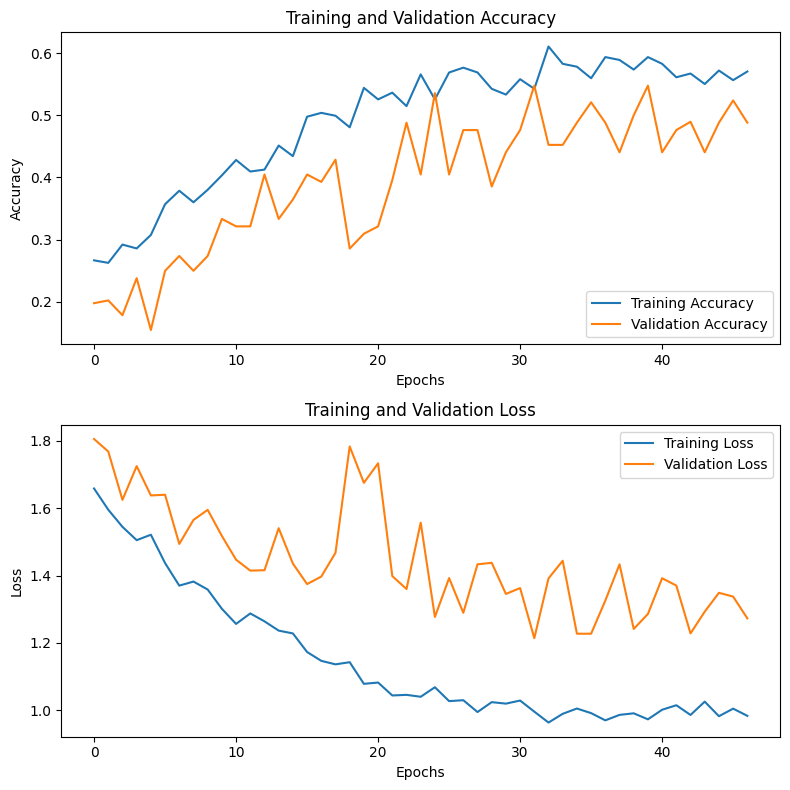

In [ ]:
plot(history)

**Obtained final validation accuracy of 55%**

Further refinement and more hyperparameter tuning may improve these results. But considering the underperformance of this model in comparison to Conv 3D models, we choose not to pursue further exploration in this direction.

### Modeling ResNet50 + LSTM64

We have tried the following before finalizing on the below given architecture:
- Model with and without batch normalization - including batch normalization has aided the training process.
- Fine-Tuning the Base Model: As with the GRU model, unfreezing some of the layers in the ResNet50 architecture wasn't performing well since the smaller size of our current dataset didn't allow for sufficient learning and made the model underfit.
- LSTM parameters - Using LSTM 128 layer instead of LSTM 64 has significantly increased the trainable parameters (almost doubled) with not enough improvement in the model performance.
- Varying batch sizes - Higher value of batch size didn't allow the model parameters to get sufficiently updated, had to use 16 batch size to observe decent amount of learning with our small dataset.
- Varying Dropout - Tried experimenting with dropouts in the range of 30%-70%. Similar to the GRU based architecture, 50% dropout gave better results in terms of model learning while still managing the overfitting problem.

In [ ]:
# Base model using ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the sequential model
model = Sequential()
model.add(Input(shape=(16, 80, 80, 3)))
model.add(TimeDistributed(base_model))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64))
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(Dense(5,activation='softmax'))

# Summary of the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape        ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ time_distributed_2         │ (None, 16, 3, 3,    │  23,587,712 │
│ (TimeDistributed)          │ 2048)               │             │
├────────────────────────────┼─────────────────────┼─────────────┤
│ time_distributed_3         │ (None, 16, 18432)   │           0 │
│ (TimeDistributed)          │                     │             │
├────────────────────────────┼─────────────────────┼─────────────┤
│ lstm (LSTM)                │ (None, 64)          │   4,735,232 │
├────────────────────────────┼─────────────────────┼─────────────┤
│ dense_2 (Dense)            │ (None, 64)          │       4,160 │
├────────────────────────────┼─────────────────────┼─────────────┤
│ batch_normalization_1      │ (None, 64)          │         256 │
│ (BatchNormalization)       │                     │             │
├────────────────────────────┼─────────────────────┼─────────────┤
│ dropout_1 (Dropout)        │ (None, 64)          │           0 │
├────────────────────────────┼─────────────────────┼─────────────┤
│ dense_3 (Dense)            │ (None, 5)           │         325 │
└────────────────────────────┴─────────────────────┴─────────────┘

 Total params: 28,327,685 (108.06 MB)

 Trainable params: 4,739,845 (18.08 MB)

 Non-trainable params: 23,587,840 (89.98 MB)

In [ ]:
checkpoint, reduce_lr, early_stopping = setup_callbacks("transfer-learning_LSTM")
history = model.fit(
                    generator(train_path, train_doc, batch_size),
                    steps_per_epoch=len(train_doc) // batch_size,
                    epochs=num_epochs,
                    validation_data=generator(val_path, val_doc, batch_size),
                    validation_steps=len(val_doc) // batch_size,
                    callbacks=[checkpoint, reduce_lr, early_stopping]
                )

Source path =  Project_data/train ; batch size = 16
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2631 - loss: 1.7794Source path =  Project_data/val ; batch size = 16

Epoch 1: val_loss improved from inf to 1.66195, saving model to saved_models/transfer-learning_LSTM_2024-10-08 03-38-54/model-00001-1.63873-0.33232-1.66195-0.25000.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - categorical_accuracy: 0.2648 - loss: 1.7760 - val_categorical_accuracy: 0.2500 - val_loss: 1.6619 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3768 - loss: 1.4354
Epoch 2: val_loss improved from 1.66195 to 1.62466, saving model to saved_models/transfer-learning_LSTM_2024-10-08 03-38-54/model-00002-1.39775-0.40495-1.62466-0.25000.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - categorical_accuracy: 0.3775 - loss: 1.4345 - val_categorical_accuracy: 0.2500 - val_loss: 1.6247 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━

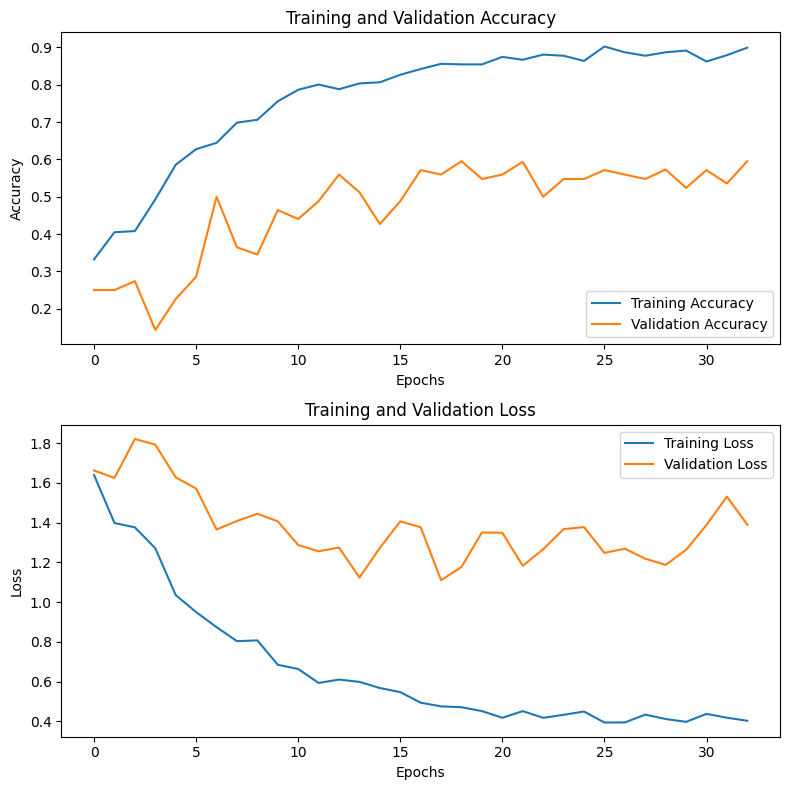

In [ ]:
plot(history)

**Obtained final validation accuracy of 56%**

Further refinement and more hyperparameter tuning may improve these results. But considering the underperformance of this model in comparison to Conv 3D models, we choose not to pursue further exploration in this direction.

## Final Model

**After trying the seven models above, we have decided that the Conv3D models are more robust and the adam optimizer with the amsgrad algorithm looks the better options from the model which we have tried**

In [ ]:
callbacks_final_model, callbacks2_final_model = model_callbacks('FinalModel')

In [ ]:
model_final = Sequential()
model_final.add(Conv3D(16, (3,3,3), padding='same', activation='relu', input_shape=(16,80,80,3)))
model_final.add(BatchNormalization())
model_final.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_final.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_final.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_final.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling3D(pool_size=(2, 2, 2)))

# A flatten layer to convert the output to a vector
model_final.add(Flatten())

model_final.add(Dense(64, activation='relu'))
model_final.add(BatchNormalization())

# Droupout layer for regularization
model_final.add(Dropout(0.3))

model_final.add(Dense(64, activation='relu'))
model_final.add(BatchNormalization())

# Droupout layer for regularization
model_final.add(Dropout(0.3))
# Output layer with 5 neurons
model_final.add(Dense(5, activation='softmax'))

In [ ]:
adam = Adam(amsgrad=True)
model_final.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 80, 80, 16)    1312      
                                                                 
 batch_normalization (BatchN  (None, 16, 80, 80, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 40, 40, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 40, 40, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 40, 40, 32)    128       
 hNormalization)                                                 
                                                        

In [ ]:
ts_start = time.time()

In [ ]:
history_final = model_final.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_final_model, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  Project_data/train ; batch size = 30
Epoch 1/50
23/23 [==============================] - 138s 6s/step - loss: 1.8400 - categorical_accuracy: 0.3439 - val_loss: 37.1572 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - 138s 6s/step - loss: 1.5200 - categorical_accuracy: 0.4434 - val_loss: 31.1808 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - 130s 6s/step - loss: 1.2581 - categorical_accuracy: 0.5068 - val_loss: 13.0124 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - 129s 6s/step - loss: 1.0694 - categorical_accuracy: 0.5732 - val_loss: 3.6953 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - 138s 6s/step - loss: 0.9804 - categorical_accuracy: 0.6124 - val_loss: 2.4975 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - 144

In [ ]:
print('Final Model finishes in: ', time.time() - ts_start, ' secs')

Final Model finishes in:  8023.427972078323  secs


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


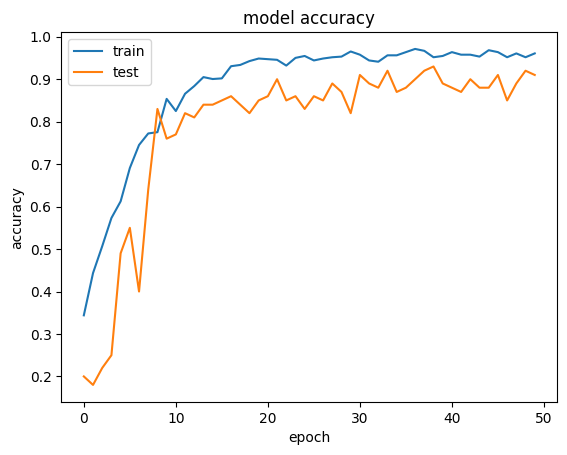

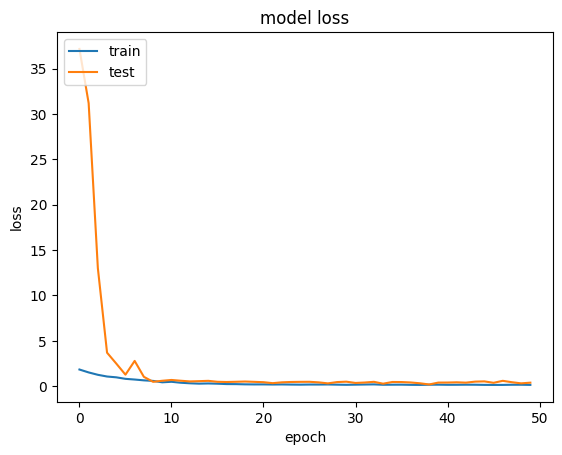

In [ ]:
plot_loss_accuracy(history_final)

In [ ]:
model_final.save('./trained_models/model_final.h5')

In [ ]:
# Recreate the exact same model, including its weights and the optimizer

load_model = tf.keras.models.load_model('./trained_models/model_final.h5')

# Display the model architecture
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 80, 80, 16)    1312      
                                                                 
 batch_normalization (BatchN  (None, 16, 80, 80, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 40, 40, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 40, 40, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 40, 40, 32)    128       
 hNormalization)                                                 
                                                        

In [ ]:
#Evaluate the final model

load_model.evaluate(val_generator,steps=validation_steps)

4/4 [==============================] - 15s 5s/step - loss: 0.4659 - categorical_accuracy: 0.8900


[0.46585792303085327, 0.8899999856948853]

### Final model observations

**After trying the seven models above, Conv3D models seem more robust and the adam optimizer with the amsgrad algorithm looks the better option from the models tried out**

* Training accuracy: 96%
* validation accuracy: 89%
* Validation loss: 0.465
* Time taken: 8023 s

The Conv3D models demonstrate robustness, effectively capturing spatial-temporal features crucial for tasks like video analysis or 3D imaging. With a high training accuracy of 96% and validation accuracy of 89%, the model shows good generalization to unseen data, indicating it is not overfitting. The use of the Adam optimizer with the AMSGrad algorithm suggests a focus on stable convergence, particularly in noisy environments. Additionally, the training duration of over 8000 seconds raises considerations for computational efficiency in deployment scenarios.






